In [1]:
# trainData

import random
import os
import pandas as pd
import numpy as np
from urllib import request

In [2]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
# with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
    a = f.read()
    outf.write(a.decode('utf-8'))
# dfTrain = pd.DataFrame(trainData, columns = ['','Word','Tag'])

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [3]:
from dont_patronize_me import DontPatronizeMe
# Initialize a dpm (Don't Patronize Me) object.
# It takes two areguments as input: 
# (1) Path to the directory containing the training set files, which is the root directory of this notebook.
# (2) Path to the test set, which will be released when the evaluation phase begins. In this example, 
# we use the dataset for Subtask 1, which the code will load without labels.
dpm = DontPatronizeMe('.', 'dontpatronizeme_pcl.tsv')
# dpm = DontPatronizeMe('/Users/benma/dontpatronizeme_v1.4', 'dontpatronizeme_pcl.tsv')

In [4]:
# This method loads the subtask 1 data
dpm.load_task1()
# which we can then access as a dataframe
df = dpm.train_task1_df

In [5]:
df

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"we 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"in libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""white house press secretary sean spicer said ...",0,0
3,4,@@7811231,disabled,nz,council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" just like we received migrants fleeing el ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""sri lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,he added that the afp will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" she has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" anja ringgren loven i ca n't find a word t...",1,4


In [6]:
df.label.value_counts()

0    9476
1     993
Name: label, dtype: int64

In [7]:
def labels2file(p, outf_path):
    with open(outf_path,'w') as outf:
        for pi in p:
            outf.write(','.join([str(k) for k in pi])+'\n')

In [8]:
!mkdir ref res

mkdir: cannot create directory ‘ref’: File exists
mkdir: cannot create directory ‘res’: File exists


In [9]:
dpm.load_test()

In [10]:
preds_task1 = [[random.randint(0,1)] for k in range(0,len(dpm.test_set))]
labels2file(preds_task1, os.path.join('res/', 'task1.txt'))

In [11]:
# !pip install -q tf-models-official

In [12]:
!pip install bert-for-tf2
!pip install sentencepiece

import tensorflow as tf
import tensorflow_hub as hub
import bert

from official.nlp import optimization  # to create AdamW optimizer

In [13]:
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [14]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [15]:
import re
#Return the cleaned text
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [16]:
sentences = []
data = list(df['text'])
for sen in data:
    sentences.append(preprocess_text(sen))


In [17]:
# df = dpm.train_task1_df.head()
# print(movie_reviews.columns.values)

In [18]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers
import bert

!pip install bert-for-tf2
!pip install sentencepiece

In [19]:



BertTokenizer = bert.bert_tokenization.FullTokenizer
#create a BERT embedding layer by importing the BERT model from hub.KerasLayer
#trainable parameter is false since we will not further train the model
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
#create a BERT vocabulary file
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
#set the text to lowercase
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
#pass vocabulary_file and to_lower_case to the BertTokenizer object
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [20]:
# Just to see how this thing tokenizes
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I don't think that you're able to visit Henry's house."))

[1045,
 2123,
 1005,
 1056,
 2228,
 2008,
 2017,
 1005,
 2128,
 2583,
 2000,
 3942,
 2888,
 1005,
 1055,
 2160,
 1012]

In [21]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [22]:
tokenized_sentences = [tokenize_reviews(sent) for sent in sentences]


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [302]:
# To see the accuracy and precision as model is training
additional_metrics = ['accuracy', tf.keras.metrics.Precision()]

# Various parameters I have not really messed with yet
batch_size = 512

# 10 seems to be a good value for this parameter
embedding_output_dims = 10
loss_function = BinaryCrossentropy()

# Idea of max sequence is to cut off sequence if exceeding certain length
# Saves a ton of time on training since longest sequences is 5501 tokens
max_sequence_length = 100
number_of_epochs = 20

# Adam is an optimizer that seems to be very standard that Ive worked with in the past.
# I have not looked to see if there are better ones for this case
optimizer = Adam()

#Parameter just to see info as model is training 
verbosity_mode = 1

# Will want to calculate number of unique words at some point, may be a useful parameter

# words = []
# for i in range(0,len(x_train)):
#   for j in range(0,len(x_train[i])):
#     words.append(x_train[i][j])
# num_distinct_words = set(words)
# max_len = 0
# words = []
# for i in range(0,len(df['text'][training_idx])):
#   if(len(df['text'][i]) > max_len):
#     max_len = len(df['text'][i])
#   for j in range(0,len(df['text'][i])):
#     words.append(df['text'][i][j])

# num_distinct_words = set(words)

# print(len(num_distinct_words))
# print(tokenized_sentences)
# print(max_len)

In [303]:
# We need to pad inputs with 0 to standardize their lengths
padded_inputs = pad_sequences(tokenized_sentences, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

# separate into training and testing sets
indices = np.random.permutation(padded_inputs.shape[0])

#Roughly a 80/20 split
training_idx, test_idx = indices[:8000], indices[8000:]
# training_idx, test_idx = indices[2000:], indices[:2000]


padded_inputs_train = padded_inputs[training_idx]
padded_inputs_test = padded_inputs[test_idx]

labels_inputs = df['label'][training_idx]


In [304]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation


# I want to figure out how to do a custom activation function so I dont have to have the code at the end of the notebook that just shifts the decision point


# def custom_activation(x):
#   val = (K.sigmoid(x) * 10)
#   if( val > 1):
#     return .99
#   else:
#     return val
# get_custom_objects().update({'custom_activation': Activation(custom_activation)})

In [305]:
model = Sequential()

# Embedding layer:
# This is just to get the model to run. Will want to actually calculate the correct value
num_unique_words = 50000
model.add(Embedding(30000, embedding_output_dims, input_length=max_sequence_length))


# Biderection lstm layer:
# Merge mode parameter is "mode by which outputs of forward and backward RNN will be combined"
# concat seems to be the best one, but I havent tested it extensively yet

# Havent messed with dropout rate much either
model.add(Bidirectional(LSTM(20, dropout = .3, return_sequences=True)))
# model.add(Bidirectional(LSTM(20, dropout = .1, return_sequences=True)))
# model.add(Bidirectional(LSTM(20, dropout = .1, return_sequences=True)))
model.add(Bidirectional(LSTM(20, dropout = .3, return_sequences=True)))

model.add(Bidirectional(LSTM(20,dropout = .3), merge_mode='concat'))


# Will want to try multiple layers, perhaps try a custom backwards layer?


# Dense layer with a sigmoid activation function
# Outputs as a probability so we can produce the binary classes
model.add(Dense(1, activation='sigmoid'))
# model.add(Activation(custom_activation, name='SpecialActivation'))
# Will want to try different activation function: relu, softmax etc


# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

# Give a summary
model.summary()

# Train the model
history = model.fit(padded_inputs_train, labels_inputs, validation_data=(padded_inputs_test, df['label'][test_idx]), batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

# Test the model after training
# test_results = model.evaluate(padded_inputs_test, y_test, verbose=False)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 10)           300000    
                                                                 
 bidirectional_51 (Bidirecti  (None, 100, 40)          4960      
 onal)                                                           
                                                                 
 bidirectional_52 (Bidirecti  (None, 100, 40)          9760      
 onal)                                                           
                                                                 
 bidirectional_53 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_17 (Dense)            (None, 1)                 41        
                                                     

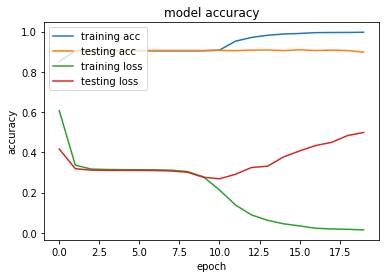

In [306]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc', 'training loss', 'testing loss'], loc='upper left')
plt.show()

We see that actually after 5-10 or so epochs, the model is now learning the "wrong" things. We can see this from the fact that the accuracy and loss decouple between the training and test sets. The model is able to figure out very precise patterns in the training set that due to randomness are not in the test set. By randomizing the test and training set before training, we've seen that this phenomena happens at different number of epochs

In [307]:
results = model.predict(padded_inputs_test)
print(results)


[[0.29742295]
 [0.00137973]
 [0.98629606]
 ...
 [0.00148842]
 [0.00160012]
 [0.00144181]]


In [308]:
# See how many positive and negative predictions in test set
negCount = 0
posCount = 0
res = []
for i in range(0,len(results)):

# I noticed the rate of positives to negatives here was significantly lower than the training set if we used a .5 cuttof
# Because of this, I significantly lower the decision point to try and capture more "true positives"
# This is really just an extension of the activation function we used earlier
# The activation function was skewing the results in a way we dont want, so this is effectively "unskewing" the results

  if(results[i]< .005):
    negCount += 1
    res.append(0)
  else:
    posCount += 1
    res.append(1)
print(posCount,negCount)

338 2131


In [309]:
preds_task1 = [[res[k]] for k in range(0,len(res))]

labels2file(preds_task1, os.path.join('res/', 'task1.txt'))

In [310]:
labels2file(dpm.train_task1_df.label[test_idx].apply(lambda x:[x]).tolist(), os.path.join('ref/', 'task1.txt'))

In [311]:
import sys
import os
import os.path
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np

# as per the metadata file, input and output directories are the arguments
[_, input_dir, output_dir] = sys.argv

# unzipped submission data is always in the 'res' subdirectory
# https://github.com/codalab/codalab-competitions/wiki/User_Building-a-Scoring-Program-for-a-Competition#directory-structure-for-submissions

# define gold data path
ref_dir = os.path.join(".", 'ref')

# define submission data path
submission_dir = os.path.join(".", 'res')
files = os.listdir(submission_dir)

# define path for scores file
outf = open(os.path.join(".",'scores.txt'),'w')

# evaluating on task 1
if 'task1.txt' in files:
    task1_res = []
    task1_gold = []
    with open(os.path.join(submission_dir,'task1.txt')) as f:
        for line in f:
            task1_res.append(int(line.strip()))
    with open(os.path.join(ref_dir,'task1.txt')) as f:
        for line in f:
            task1_gold.append(int(line.strip()))
    # task 1 scores
    t1p = precision_score(task1_gold, task1_res)
    t1r = recall_score(task1_gold, task1_res)
    t1f = f1_score(task1_gold, task1_res)
    # task1
    outf.write('task1_precision:'+str(t1p)+'\n')
    outf.write('task1_recall:'+str(t1r)+'\n')
    outf.write('task1_f1:'+str(t1f)+'\n')    


outf.close()